In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
from argparse import Namespace
from pathlib import Path
from typing import Dict, Type, Union

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import yaml
from torch.utils.data import DataLoader

from double_jig_gen.data import ABCDataset, get_folkrnn_dataloaders, pad_batch
from double_jig_gen.tokenizers import Tokenizer
from double_jig_gen.models import SimpleRNN, Transformer
from double_jig_gen.utils import get_model_from_checkpoint

logging.basicConfig()
LOGGER = logging.getLogger(__name__)
LOGGER.setLevel("DEBUG")

In [3]:
def _get_most_recent_path(paths):
    """Returns the most recently created path from a list of paths.

    Args:
        paths: a list of paths to check.

    Returns:
        the most recently created path.
    """
    return max(paths, key=os.path.getctime)

In [4]:
expt_id = 5
scratch_path = "/disk/scratch_fast"
expt_dirpath = Path(f"{scratch_path}/s0816700/logs/lightning_logs/version_{expt_id}")
checkpoint_dirpath = Path(expt_dirpath, "checkpoints")
ckpt_paths = [
    path for path in checkpoint_dirpath.iterdir() if str(path).endswith(".ckpt")
]
latest_ckpt_path = _get_most_recent_path(ckpt_paths)

experiment_args_path = Path(expt_dirpath, "experiment_args.yaml")
# The yaml file has lowcase trainer in tag:
# python/name:pytorch_lightning.trainer.trainer._gpus_arg_default
# so loading fails with SafeLoader, have to use BaseLoader
# args = pl.core.saving.load_hparams_from_yaml(str(experiment_args_path))
with open(str(experiment_args_path), 'r') as fh:
    args_dict = yaml.load(fh, Loader=yaml.BaseLoader)
args_dict['model_load_from_checkpoint'] = latest_ckpt_path
args = Namespace()
vars(args).update(args_dict)
args

Namespace(accumulate_grad_batches='1', amp_backend='native', amp_level='O2', auto_lr_find='false', auto_scale_batch_size='false', auto_select_gpus='false', batch_size='64', benchmark='false', check_val_every_n_epoch='1', checkpoint_callback='true', dataset='folkrnn', default_root_dir='/disk/scratch_fast/s0816700/logs', deterministic='false', distributed_backend='null', dropout='0.5', early_stop_callback='false', early_stopping_patience='50', embedding_padding_idx='0', fast_dev_run='false', folkrnn_data_path='/disk/scratch_fast/s0816700/data/folk-rnn/data_v3', gpus='0,', gradient_clip_val='0', learning_rate='0.003', limit_test_batches='1.0', limit_train_batches='1.0', limit_val_batches='1.0', log_gpu_memory='null', log_level='INFO', log_save_interval='100', logger='true', lr_decay_gamma='0.5', lr_decay_patience='10', max_epochs='1000', max_steps='null', min_epochs='1', min_steps='null', model='rnn', model_batch_size='64', model_load_from_checkpoint=PosixPath('/disk/scratch_fast/s0816700

In [5]:
ckpt_path = Path(args.model_load_from_checkpoint).expanduser().resolve()

In [6]:
ckpt_path

PosixPath('/disk/scratch_fast/s0816700/logs/lightning_logs/version_5/checkpoints/epoch=483.ckpt')

In [7]:
MODELS: Dict[str, Union[Type[SimpleRNN], Type[Transformer]]] = {
    "rnn": SimpleRNN,
    "transformer": Transformer,
}

In [8]:
ModelClass = MODELS[args.model]

In [9]:
model = get_model_from_checkpoint(ckpt_path, ModelClass)

In [10]:
model

SimpleRNN(
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (encoder_layer): Embedding(106, 256, padding_idx=0)
  (rnn_layer): LSTM(256, 512, num_layers=3, dropout=0.5)
  (decoder_layer): Linear(in_features=512, out_features=106, bias=True)
)

In [11]:
len(list(model.parameters()))

15

In [12]:
len(list(model.named_parameters()))

15

In [13]:
param_dict = dict(model.named_parameters())

In [14]:
param_dict.keys()

dict_keys(['encoder_layer.weight', 'rnn_layer.weight_ih_l0', 'rnn_layer.weight_hh_l0', 'rnn_layer.bias_ih_l0', 'rnn_layer.bias_hh_l0', 'rnn_layer.weight_ih_l1', 'rnn_layer.weight_hh_l1', 'rnn_layer.bias_ih_l1', 'rnn_layer.bias_hh_l1', 'rnn_layer.weight_ih_l2', 'rnn_layer.weight_hh_l2', 'rnn_layer.bias_ih_l2', 'rnn_layer.bias_hh_l2', 'decoder_layer.weight', 'decoder_layer.bias'])

In [15]:
param_dict['encoder_layer.weight'].shape

torch.Size([106, 256])

Here we show that something has been learned! The first four tokens are:
* 0: `<pad>` - padding token
* 1: `<unk>` - unknown/rare token
* 2: `<s>` - start sequence
* 3: `</s>` - end sequence

The encoder weights show that: nothing is learned for `<pad>`, `<unk>`, and `</s>` as they have their initialised weights near zero; something is learned for `<s>` as these have weights. This is as expected because nothing should follow pad and end seq, and there are no unk tokens in this dataset!

The decoder weights show the same, except nothing is learned for `<s>`, and something for `</s>`. Again, this is expected since the start sequence token should never be predicted, and the end sequence token should be predicted a lot.

In [16]:
W_enc = param_dict['encoder_layer.weight'].detach()

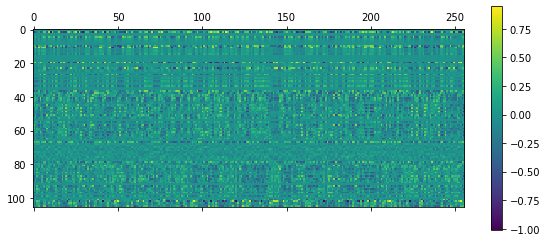

In [17]:
plt.matshow(W_enc)
plt.colorbar();

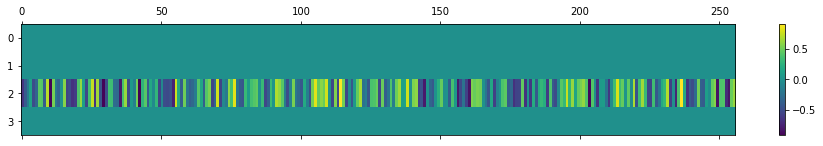

In [18]:
plt.matshow(W_enc[:4], aspect='auto', interpolation='none')
plt.colorbar();

In [19]:
W_dec = param_dict['decoder_layer.weight'].detach()

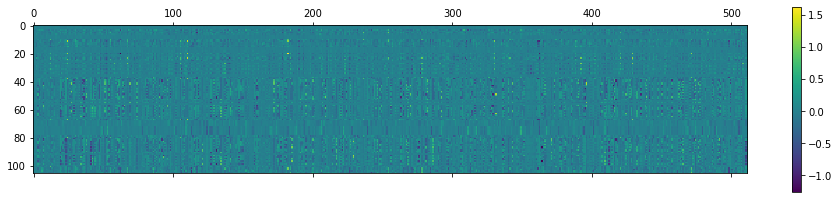

In [20]:
plt.matshow(W_dec)
plt.colorbar();

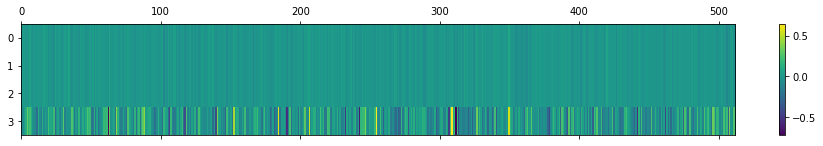

In [21]:
plt.matshow(W_dec[:4], aspect='auto', interpolation='none')
plt.colorbar();

# Producing generations

In [22]:
DEVICE_ID = 7
LOGGER.info(f"Changing to device {DEVICE_ID}")
os.environ["CUDA_VISIBLE_DEVICES"] = f"{DEVICE_ID}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INFO:__main__:Changing to device 7


In [23]:
dataloaders = get_folkrnn_dataloaders(
    args.folkrnn_data_path,
    batch_size=64,
    num_workers=2,
    pin_memory=True
)

In [24]:
valid_dataloader = dataloaders[1]

In [25]:
print(valid_dataloader.dataset)

vocabulary size: 106
vocabulary (each token separated by a space): 
<pad> <unk> <s> </s> (2 (3 (4 (5 (6 (7 - /2 /2< /2> /3 /4 /4< /8 12 16 2 2< 2> 3 3/2 3/4 3> 4 4> 5 5/2 6 7 7/2 8 9 9/2 :| < =A =A, =B =B, =C =C, =D =D, =E =E, =F =F, =G =G, =a =a' =b =b' =c =c' =d =d' =e =e' =f =f' =g =g' > K:dor K:maj K:min K:mix M:12/8 M:2/4 M:3/2 M:3/4 M:4/4 M:6/8 M:9/8 [ ] ^A ^A, ^C ^C, ^D ^D, ^F ^F, ^G ^G, ^a ^a' ^c ^c' ^d ^d' ^f ^f' ^g ^g' z | |1 |2 |:
dataset_size: 2240
tune length stats:
	* max 514
	* mean 166.97946428571427
	* median 152.0
	* min 38


In [38]:
model.train()

SimpleRNN(
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (encoder_layer): Embedding(106, 256, padding_idx=0)
  (rnn_layer): LSTM(256, 512, num_layers=3, dropout=0.5)
  (decoder_layer): Linear(in_features=512, out_features=106, bias=True)
)

In [39]:
model.training

True

In [40]:
model.eval()

SimpleRNN(
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (encoder_layer): Embedding(106, 256, padding_idx=0)
  (rnn_layer): LSTM(256, 512, num_layers=3, dropout=0.5)
  (decoder_layer): Linear(in_features=512, out_features=106, bias=True)
)

In [41]:
model.training

False

In [27]:
model = model.to(device)

In [28]:
tokenizer = valid_dataloader.dataset.tokenizer
# token_sequences = [
#     ["<s>"],
#     ["<s>", "M:6/8"],
#     ["<s>", "M:6/8", "K:mix"],
#     [""]
# ]
token_sequences = (
    [["<s>"]] * 20 +
    [["<s>", "M:6/8"]] * 5 + 
    [["<s>", "M:6/8", "K:mix"]] * 5
)
priming_dataset = ABCDataset(
    tunes=token_sequences,
    tokens=valid_dataloader.dataset.tokens,
    wrap_tunes=False,
)

In [29]:
pad_token_idx = valid_dataloader.dataset.tokenizer.pad_token_index
pad_priming_batch = lambda batch: pad_batch(batch, pad_token_idx)

In [30]:
priming_loader = DataLoader(
    priming_dataset,
    batch_size=len(priming_dataset),
    shuffle=False,
    num_workers=4,
    pin_memory=False,
    collate_fn=pad_priming_batch,
)

In [33]:
end_token_idx = tokenizer.end_token_index
max_seq_len = 1000
for batch_item in priming_loader:
    padded_data, seq_lens = batch_item
    seq_lens = np.array(seq_lens)
    padded_data = padded_data.to(device)
    still_generating = np.array([True] * padded_data.shape[1])
    for ii in range(max_seq_len):
        next_tokens = model.generate_next_token(
            padded_data[:, still_generating], 
            seq_lens[still_generating],
            topk=5
        )
        padded_data = F.pad(
            input=padded_data,
            pad=(0, 0, 0, 1),  # Pad bottom
            mode="constant",
            value=pad_token_idx,
        )
        padded_data[seq_lens[still_generating], still_generating] = next_tokens
        if all(padded_data[-1] == 0):
            padded_data = padded_data[:-1]
        seq_lens[still_generating] += 1
        last_tokens = padded_data[seq_lens - 1, range(padded_data.shape[1])]
        still_generating = np.array((last_tokens != end_token_idx).tolist())
        if still_generating.sum() == 0:
            break
        
    generations = [tokenizer.untokenize(seq.cpu()) for seq in padded_data.T]

In [36]:
for idx, gen in enumerate(generations):
    print(' '.join(gen[:seq_lens[idx]]))
    print()

<s> M:4/4 K:maj ^G =F =F 2 ^F ^D ^D 2 | ^G ^C =F ^C ^D ^C ^C ^A, | ^G, =F =F 2 ^F ^D ^d 2 | =f ^c ^d =c ^c ^A ^G =F | ^G =F =F 2 ^F ^D ^D 2 | ^G ^C ^C ^D =F ^C ^C ^A, | ^G, ^C =F ^G ^c =f ^d ^c | ^A ^d ^d =c ^c 2 =f ^c | ^d =f ^d ^c ^A ^c =c ^c | ^d ^c =c ^A ^G 2 ^c =f | ^d ^c ^A ^d ^d ^c ^A ^G | ^A ^c =c ^c ^d ^c =c ^d | ^d =f ^d ^c ^A ^c ^d =c | ^c ^d ^c ^A ^G 3 =F | ^F =F ^D =F ^C ^D =F ^c | ^G =F ^A =F ^G 2 ^F =F | </s>

<s> M:6/8 K:maj |: ^C ^D =F ^D 2 ^C | ^A, ^C ^A, ^G, 2 ^G, | ^C ^D =F ^G =F ^G | ^c =c ^A ^G =F ^C | ^F ^A ^F =F ^C =F | ^D ^C ^D =F ^D ^C | ^C =F ^G ^A =c ^c | ^G =F ^C ^D 2 ^C :| |: =F ^G ^G ^G 2 ^G | =F ^G ^G ^G 2 ^A | ^c ^d ^c ^A ^G =F | ^C =F ^G ^A ^c ^G | ^G ^A ^c ^d ^c ^d | =f ^d ^c ^d ^c ^A | ^G 2 =F ^G ^A ^G | =F ^D ^C ^C 2 ^G, :| </s>

<s> M:4/4 K:maj =G 2 =E =C =G =C =E =C | =G =C =C 2 =G =C =E =C | =A 2 =F =A =D =C =F =A | =A 2 =F =A =A =G =E =A | =G 2 =E =C =G, =C =E =C | =G =C =C 2 =G =C =E =C | =F =G =A =B =c =A =G =F | =E =D =C =D =E =C =C 2 :| =e =

In [45]:
tokenizer.end_token_index

3

In [48]:
for batch_item in priming_loader:
    padded_data, seq_lens = batch_item
    padded_data = padded_data.to(device)
    generations, gen_seq_lens = model.generate_tunes(
        padded_data,
        seq_lens,
        max_nr_generation_steps=10,
        end_token_idx=3,
    )

100%|██████████| 10/10 [00:00<00:00, 169.32it/s]


In [52]:
generations.shape, gen_seq_lens

(torch.Size([13, 30]),
 array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13]))

In [55]:
generations = [tokenizer.untokenize(seq.cpu()) for seq in generations.T]

In [58]:
for idx, gen in enumerate(generations):
    print(f"Tune {idx}:")
    print(' '.join(gen[:gen_seq_lens[idx]]))
    print()

Tune 0:
<s> M:2/4 K:maj |: =C > =C | =G > =G

Tune 1:
<s> M:4/4 K:min |: =A =B | =c =e =A =e

Tune 2:
<s> M:4/4 K:min |: =f ^d ^c =f ^a 2 ^g

Tune 3:
<s> M:2/4 K:maj |: ^G /2 ^A /2 ^G /2 =F

Tune 4:
<s> M:9/8 K:maj |: =G 2 =G =G =F =E =G

Tune 5:
<s> M:4/4 K:maj |: ^C 2 =F ^C ^G ^C =F

Tune 6:
<s> M:2/4 K:maj |: =C /2 =D /2 | =E =E

Tune 7:
<s> M:6/8 K:maj |: =G 2 =G =E 2 =D |

Tune 8:
<s> M:4/4 K:maj |: =G 2 =G 2 =G > =A

Tune 9:
<s> M:4/4 K:mix |: =G =A =B =G =G =A =B

Tune 10:
<s> M:4/4 K:maj =G =F | =E =C =C 2 =G

Tune 11:
<s> M:6/8 K:dor =D 2 =A =c 2 =G | =A

Tune 12:
<s> M:6/8 K:min |: =f | ^c =c ^A =c ^c

Tune 13:
<s> M:4/4 K:maj |: ^C =F ^G =F ^F 2 =F

Tune 14:
<s> M:4/4 K:maj =G =A =G =F =E =C =E =G

Tune 15:
<s> M:6/8 K:maj |: ^C | ^D 3 ^G 3 |

Tune 16:
<s> M:6/8 K:maj |: ^C ^D ^C ^C 2 ^G |

Tune 17:
<s> M:4/4 K:maj ^G ^A ^c ^d =f 2 ^d =f

Tune 18:
<s> M:4/4 K:maj |: =G 2 =G =A =G 2 =G

Tune 19:
<s> M:6/8 K:maj |: ^C =F ^G ^c 2 =f |

Tune 20:
<s> M:6/8 K:maj |: =F ^D | ^C =F 

In [59]:
for batch_item in priming_loader:
    padded_data, seq_lens = batch_item
    padded_data = padded_data.to(device)
    generations, gen_seq_lens = model.generate_tunes(
        padded_data,
        seq_lens,
        max_nr_generation_steps=10,
        tokenizer=tokenizer,
    )

100%|██████████| 10/10 [00:00<00:00, 185.00it/s]


In [60]:
for idx, gen in enumerate(generations):
    print(f"Tune {idx}:")
    print(' '.join(gen[:gen_seq_lens[idx]]))
    print()

Tune 0:
<s> M:4/4 K:maj |: ^G =F ^G ^A ^G =F ^D

Tune 1:
<s> M:6/8 K:maj |: =C 2 =E =G 2 =A |

Tune 2:
<s> M:4/4 K:dor |: ^A 2 ^d ^c ^A 2 ^d

Tune 3:
<s> M:4/4 K:maj ^C 2 =F ^C ^D ^C =F ^C

Tune 4:
<s> M:2/4 K:maj |: =F /2 ^F /2 | ^G =F

Tune 5:
<s> M:6/8 K:mix |: =G 2 =c =c =B =c |

Tune 6:
<s> M:4/4 K:mix |: =G 3 =A =G =F =E =F

Tune 7:
<s> M:6/8 K:maj |: =F 2 ^G =F ^C =F |

Tune 8:
<s> M:6/8 K:maj |: =G | =c =d =e =d =c

Tune 9:
<s> M:4/4 K:maj |: =G | =c 2 =c =A =G

Tune 10:
<s> M:4/4 K:maj |: =G 2 | =c =d =e =f

Tune 11:
<s> M:3/4 K:maj |: =G =A /2 =G /2 | =E

Tune 12:
<s> M:3/4 K:maj |: ^G > ^A ^c =c ^c ^A

Tune 13:
<s> M:4/4 K:maj |: ^G 2 ^G ^A ^G =F ^D

Tune 14:
<s> M:4/4 K:maj |: =G > =A | =G 2 =E

Tune 15:
<s> M:4/4 K:maj |: ^C 2 ^C 2 =F ^F ^G

Tune 16:
<s> M:3/4 K:maj =G =F | =E 2 =E 2 =G

Tune 17:
<s> M:4/4 K:maj |: =F ^D | ^C =F ^G ^c

Tune 18:
<s> M:3/4 K:dor =D 2 =E =F =G 2 | =G

Tune 19:
<s> M:2/4 K:min |: =f | =f ^A =c /2 ^c

Tune 20:
<s> M:6/8 K:maj =C 2 =D =E =D =C |

In [63]:
for batch_item in priming_loader:
    padded_data, seq_lens = batch_item
    padded_data = padded_data.to(device)
    generations, gen_seq_lens = model.generate_tunes(
        padded_data,
        seq_lens,
        max_nr_generation_steps=1000,
        tokenizer=tokenizer,
    )

 40%|████      | 400/1000 [00:08<00:12, 46.71it/s]


In [64]:
for idx, gen in enumerate(generations):
    print(f"Tune {idx}:")
    print(' '.join(gen[:gen_seq_lens[idx]]))
    print()

Tune 0:
<s> M:3/4 K:maj =G 2 | =c 2 =G > =E =C > =E | =F 2 =A 2 (3 =c =B =A | =G 2 =E > =G =c > =e | =d > =B =G 2 =A > =G | =c 2 =G > =E =C > =E | =F 2 =A > =c =F > =A | =G > =B =d > =f =e > =d | =c 4 :| |: =c > =B | =c > =B =c > =d =e > =c | =A > =B =c < =e =G > =g | =f > =e =d > =e =c > =B | (3 =d =e =d (3 =c =B =A =G > =A | =c 2 =c > =B (3 =d =c =B | =A > =B =c > =G (3 =E =F =G | =A > =F =A > =B (3 =c =B =A | =G 2 =c > =B :| |: =G > =F | =E > =F =G > =A =G > =E | =C > =E =G > =c (3 =e =f =g | =f > =d =e > =c (3 =d =c =B | =c > =e =d > =c =B > =A | =G > =c =A > =c =G > =c | =E 2 =c > =d =e > =c | =d > =B =c > =e (3 =d =c =B | =c 4 :| </s>

Tune 1:
<s> M:3/4 K:maj ^C ^D |: =F 4 =F ^D | =F ^G =F ^D ^C ^D | =F 3 ^G ^G =F | ^G 3 ^A ^G 2 | ^A 4 ^A ^G | ^A ^c 3 ^G 2 | ^G 3 =F ^D ^C | ^D 4 ^C ^D | =F 3 ^D =F ^G | =F ^A =F ^G 3 | ^C 3 ^D ^C ^D | =F 4 ^D ^C | ^A, 3 ^G, ^A, ^C | ^D 3 =F ^D ^C |1 ^C 4 =F ^C | ^C 4 ^G, ^C :| |2 ^C 3 =F ^G ^C | ^C 6 | ^C 2 ^C ^C ^D =F | ^G 4 ^A ^G | =F 4 ^C =F | 

In [86]:
padded_data

tensor([[ 2,  2,  2,  1],
        [ 0, 77, 77,  0],
        [ 0,  0, 71,  0]], device='cuda:0')

In [87]:
F.pad(input=padded_data, pad=(0, 0, 0, 1))

tensor([[ 2,  2,  2,  1],
        [ 0, 77, 77,  0],
        [ 0,  0, 71,  0],
        [ 0,  0,  0,  0]], device='cuda:0')

In [69]:
next_tokens

tensor([77, 69, 20], device='cuda:0')

In [62]:
F.softmax(padded_data, dim=-1).multinomial(1)

tensor([[0],
        [0],
        [1]], device='cuda:0')

In [36]:
a, b = padded_data

In [70]:
F.softmax(a, dim=-1)

tensor([[[5.6155e-01, 2.4774e-01, 8.1150e-02, 7.5658e-02, 3.3905e-02],
         [5.4311e-01, 2.5668e-01, 8.7032e-02, 7.9248e-02, 3.3932e-02],
         [3.9349e-01, 2.0174e-01, 1.7844e-01, 1.3053e-01, 9.5797e-02]],

        [[3.9733e-01, 2.1074e-01, 1.5605e-01, 1.2381e-01, 1.1206e-01],
         [6.9920e-01, 1.2266e-01, 1.1965e-01, 5.8452e-02, 2.8411e-05],
         [3.9733e-01, 2.1074e-01, 1.5605e-01, 1.2381e-01, 1.1206e-01]]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [38]:
b

tensor([[[ 76,  77,  75,  73,  78],
         [ 76,  77,  75,  73,  78],
         [  3,  20,  93,  90,  99]],

        [[ 20,  76, 102,  11,  67],
         [ 69,  70,  68,  71,  76],
         [ 20,  76, 102,  11,  67]]], device='cuda:0')

In [80]:
rng = np.random.RandomState(42)
rng = np.random.default_rng()

In [84]:
b.shape

torch.Size([2, 3, 5])

In [81]:
rng.choice(b.cpu(), axis=-1)

array([[76, 76,  3],
       [20, 69, 20]])

In [38]:
b

NameError: name 'b' is not defined